<a href="https://colab.research.google.com/github/sarvasvaKhare/BubbleMassTransfer/blob/main/bubblePathClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from typing import List, Tuple
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import torch as pt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from google.colab import drive
drive.mount('/content/drive')
# make results reproducible
pt.manual_seed(0)

# increase plot resolution
plt.rcParams["figure.dpi"] = 160

# create output directory
output = "output"
!mkdir -p $output

Mounted at /content/drive


In [2]:
data_path = "/content/drive/MyDrive/path_shape_regimes/"
regimes = ["I", "II", "III", "IV", "V"]
raw_data_files = [f"regime_{regime}.csv" for regime in regimes]
files = [pd.read_csv(data_path + file_name, header=0, names=["Ga", "Eo"]) for file_name in raw_data_files]
for data, regime in zip(files, regimes):
    data["regime"] = regime
data = pd.concat(files, ignore_index=True)
data.sample(5)

,Ga,Eo,regime
75,50.091,39.89600,V
22,39.929,0.50619,II
72,507.670,0.94460,IV
20,32.188,10.21200,II
3,7.015,4.00600,I


In [3]:
data.describe()

,Ga,Eo
count,103.000000,103.000000
mean,122.638672,37.759512
std,149.717655,58.145646
min,6.939000,0.099640
25%,22.600500,1.000500
50%,60.116000,10.046000
75%,186.545000,48.188500
max,518.290000,212.910000


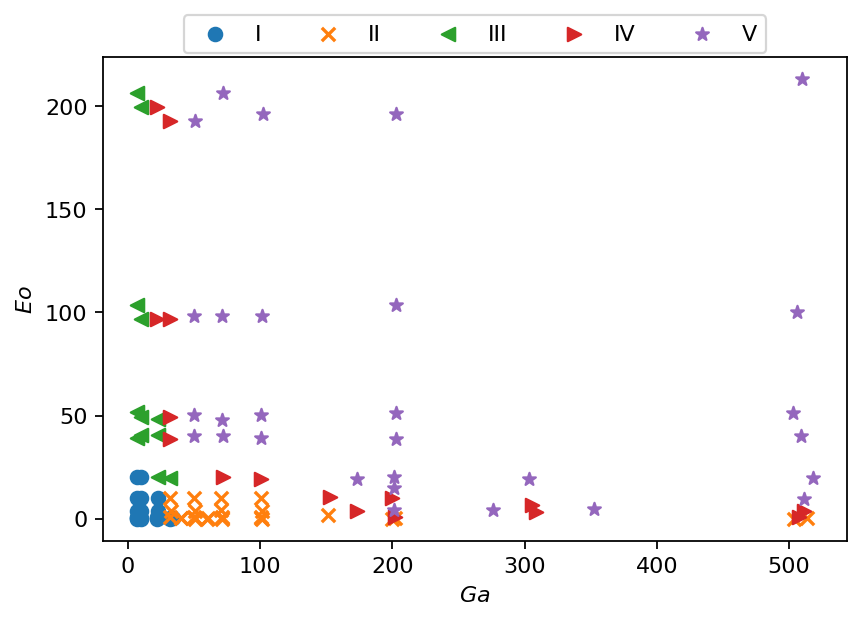

In [4]:
markers = ["o", "x", "<", ">", "*"]
for regime, marker in zip(regimes, markers):
    plt.scatter(data[data["regime"] == regime].Ga, data[data["regime"] == regime].Eo,
                marker=marker, label=regime)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.11), ncol=5) #ncols not suppoted??
plt.xlabel(r"$Ga$")
plt.ylabel(r"$Eo$")
plt.savefig(f"{output}/ga_eo_data_raw.svg", bbox_inches="tight")

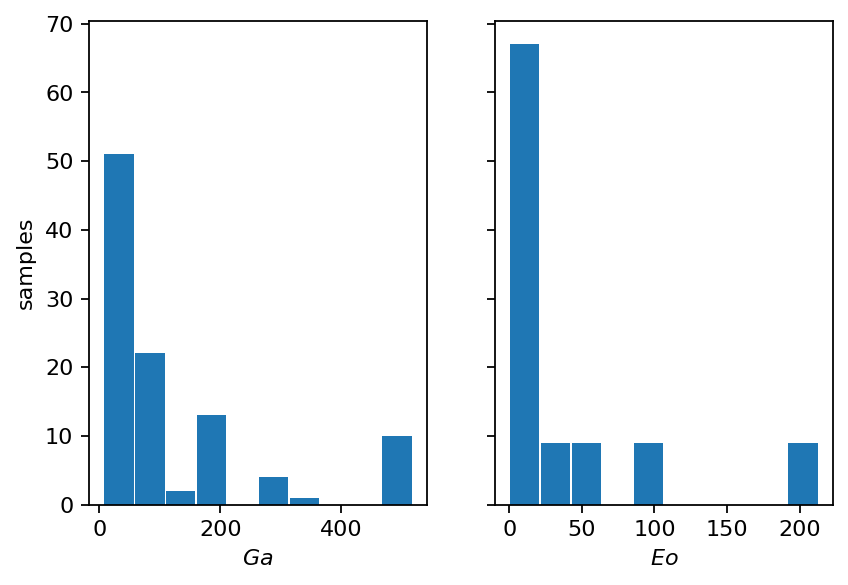

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(data.Ga, rwidth=0.95)
ax1.set_xlabel(r"$Ga$")
ax1.set_ylabel(r"samples")
ax2.hist(data.Eo, rwidth=0.95)
ax2.set_xlabel(r"$Eo$")
plt.savefig(f"{output}/ga_eo_raw_histogram.svg", bbox_inches="tight")

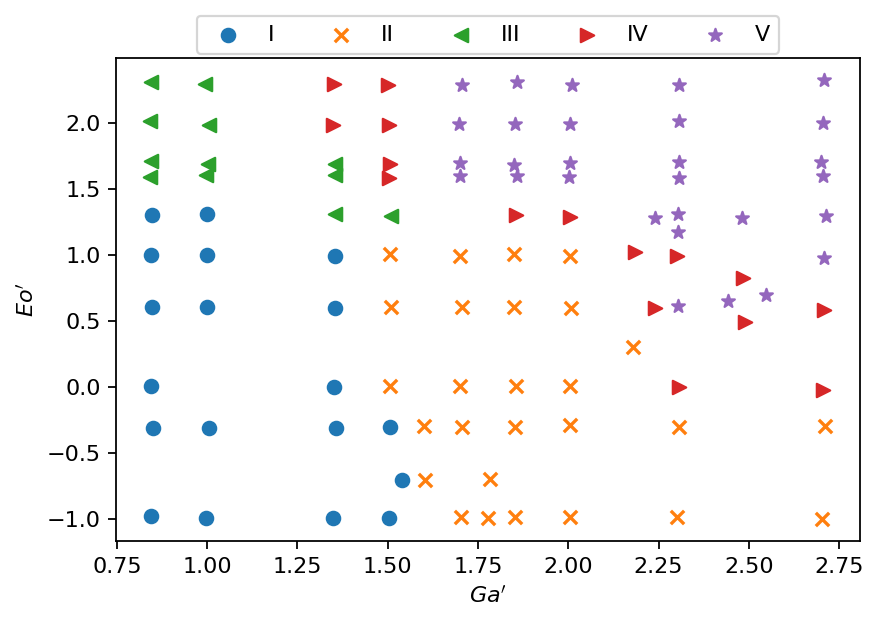

In [6]:
logData = data[["Ga", "Eo"]].apply(np.log10)
logData["regime"] = data["regime"].copy()

for regime, marker in zip(regimes, markers):
    plt.scatter(logData[logData["regime"] == regime].Ga, logData[logData["regime"] == regime].Eo,
                marker=marker, label=regime)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.11), ncol=5) #ncols not suppoted??
plt.xlabel(r"$Ga^\prime$")
plt.ylabel(r"$Eo^\prime$")
plt.savefig(f"{output}/ga_eo_log.svg", bbox_inches="tight")

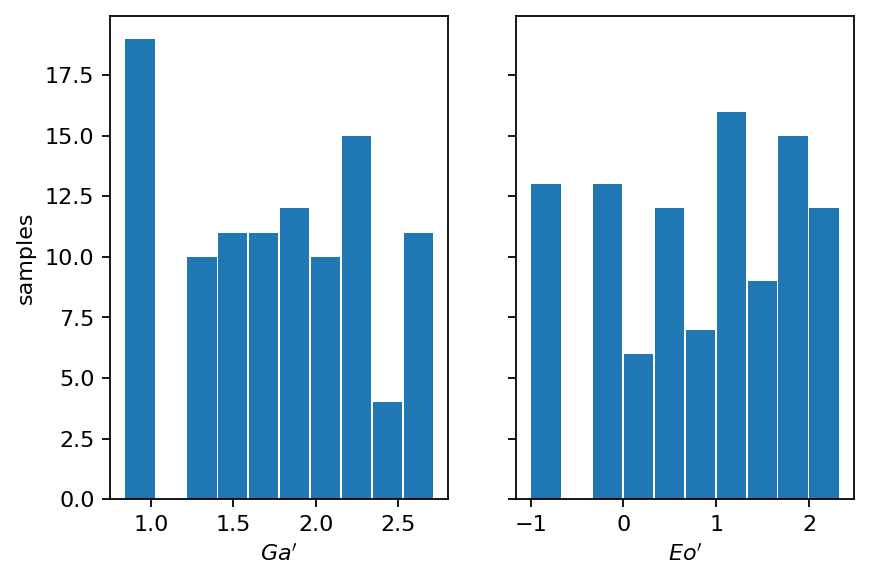

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(logData.Ga, rwidth=0.95)
ax1.set_xlabel(r"$Ga^\prime$")
ax1.set_ylabel(r"samples")
ax2.hist(logData.Eo, rwidth=0.95)
ax2.set_xlabel(r"$Eo^\prime$")
plt.savefig(f"{output}/ga_eo_log_histogram.svg", bbox_inches="tight")

In [8]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(60, input_shape=(2,), activation='sigmoid')) 
model.add(tf.keras.layers.Dense(60,activation='sigmoid'))
model.add(tf.keras.layers.Dense(5,activation='log_softmax'))
# categorial cross entropy taking logarithmic probabilities
criterion = tf.keras.losses.CategoricalCrossentropy()
# stochastic gradient decent: ADAM
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005,beta_1=0.9999,beta_2=0.999999,epsilon=1e-17,amsgrad=True,name='Adam'),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=tf.keras.metrics.SparseCategoricalAccuracy())
model.summary()
                

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60)                180       
                                                                 
 dense_1 (Dense)             (None, 60)                3660      
                                                                 
 dense_2 (Dense)             (None, 5)                 305       
                                                                 
Total params: 4,145
Trainable params: 4,145
Non-trainable params: 0
_________________________________________________________________


In [9]:
features = logData[["Ga", "Eo"]].values
logData["ordinal"] = 0.0
for i, r in enumerate(regimes):
    logData.ordinal.mask(logData.regime == r, float(i), inplace=True)
labels =logData.ordinal.values
history = model.fit(features,labels, epochs=2000,steps_per_epoch=5)

Epoch 1/2000
5/5 [==============================] - 1s 5ms/step - loss: 1.5958 - sparse_categorical_accuracy: 0.2427
Epoch 2/2000
5/5 [==============================] - 0s 4ms/step - loss: 1.5674 - sparse_categorical_accuracy: 0.2718
Epoch 3/2000
5/5 [==============================] - 0s 4ms/step - loss: 1.5326 - sparse_categorical_accuracy: 0.3301
Epoch 4/2000
5/5 [==============================] - 0s 5ms/step - loss: 1.5038 - sparse_categorical_accuracy: 0.4660
Epoch 5/2000
5/5 [==============================] - 0s 4ms/step - loss: 1.4934 - sparse_categorical_accuracy: 0.4951
Epoch 6/2000
5/5 [==============================] - 0s 4ms/step - loss: 1.4736 - sparse_categorical_accuracy: 0.4369
Epoch 7/2000
5/5 [==============================] - 0s 5ms/step - loss: 1.4520 - sparse_categorical_accuracy: 0.4175
Epoch 8/2000
5/5 [==============================] - 0s 5ms/step - loss: 1.4258 - sparse_categorical_accuracy: 0.4369
Epoch 9/2000
5/5 [==============================] - 0s 4ms/step 

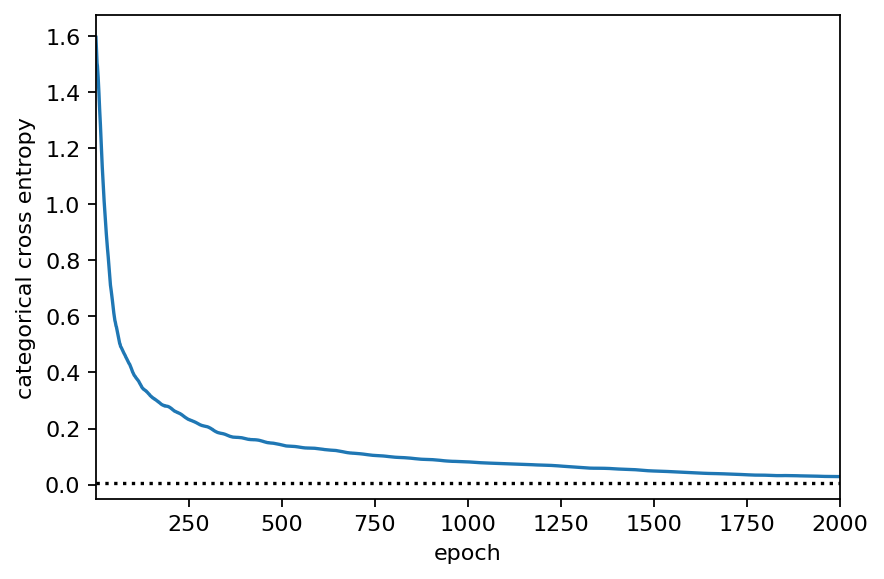

In [10]:
plt.plot(range(1, len(history.history['loss'])+1), history.history['loss'])
plt.xlabel("epoch")
plt.ylabel("categorical cross entropy")
plt.xlim(1.0, len(history.history['loss'])+1)
plt.axhline(5.0e-3, 0.0, 1.0, ls=":", c="k")
plt.savefig(f"{output}/network_classification_loss.svg", bbox_inches="tight")

In [11]:
training_data=logData[["Ga","Eo"]]
target_data=[]
for regime in logData["regime"]:
  if regime=="I":
     target_data.append(1)
  if regime=="II":
    target_data.append(2)
  if regime=="III":
    target_data.append(3)
  if regime=="IV":
    target_data.append(4)
  if regime=="V":
    target_data.append(5);
target_data=np.array(target_data)
training_data=np.array(training_data)


7813/7813 [==============================] - 14s 2ms/step
[[   0.        -58.46314   -41.160656  -68.02485  -145.33589 ]
 [   0.        -58.410374  -41.169678  -67.93992  -145.25621 ]
 [   0.        -58.357086  -41.177143  -67.855064 -145.17531 ]
 ...
 [-142.18889   -63.455193  -82.89894   -23.171167    0.      ]
 [-142.19771   -63.46645   -82.91038   -23.180964    0.      ]
 [-142.20547   -63.47692   -82.92081   -23.190237    0.      ]]
[0.01 0.01 0.01 ... 4.01 4.01 4.01]


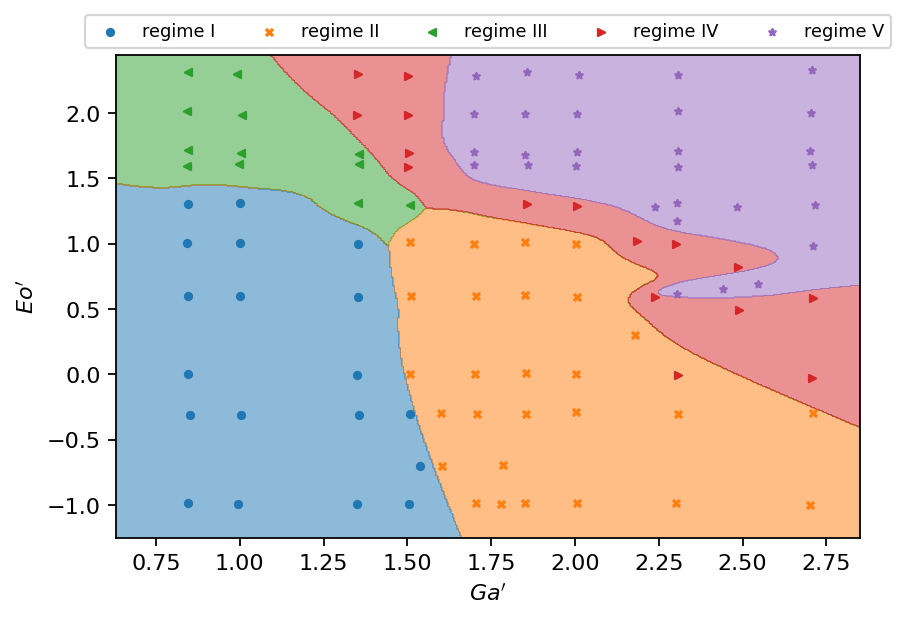

In [12]:
xx,yy=np.meshgrid(
     np.linspace(logData.Ga.min()*0.75, logData.Ga.max()*1.05, 500),
     np.linspace(logData.Eo.min()*1.25, logData.Eo.max()*1.05, 500)
 )
prob = model.predict(np.array([xx.ravel(), yy.ravel()]).T)
print(prob)
prediction = np.argmax(prob,axis=1) + 0.01
print(prediction)
fig, ax = plt.subplots()
cmap = ListedColormap([f"C{i}" for i in range(5)])
ax.contourf(xx, yy, prediction.reshape(xx.shape), cmap=cmap, alpha=0.5)
for regime, marker in zip(regimes, markers):
    ax.scatter(logData[logData["regime"] == regime].Ga, logData[logData["regime"] == regime].Eo,
               marker=marker, s=10, label="regime {}".format(regime))
ax.set_xlabel(r"$Ga^\prime$")
ax.set_ylabel(r"$Eo^\prime$")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=5, fontsize=8)
plt.savefig(f"{output}/network_multiclass_prediction.svg", bbox_inches="tight")